# Plot predictions and data for best parameter combination  

This script visualizes the LIs and predictions made

### import modules

In [1]:
%matplotlib inline

In [2]:
import os
import fnmatch

import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pylab as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn import preprocessing, model_selection, metrics
from nilearn import plotting

import pickle

In [3]:
sns.set_style('white')
sns.set_context('poster')

### load labeler

In [4]:
myLabeler = pickle.load(open('../models/myLabeler.p', 'rb'))

In [5]:
myLabeler.classes_

array(['bilateral', 'inconclusive', 'left', 'right'], dtype=object)

### load list with patients

In [6]:
my_train = pickle.load(open('../models/my_nest.p', 'rb'))
my_test = pickle.load(open('../models/my_test.p', 'rb'))

In [7]:
my_all = my_train + my_test

In [8]:
len(my_all)

783

### get all summary data

In [9]:
allAvgLiDf = pd.DataFrame()

for pGroup, pName in my_all:
    try:
        csv = '../data/processed/csv/meanTable_%s.csv' % pName

        pDf = pd.read_csv(csv, index_col=[0, 1], header=0)
        pDf = pDf.loc['1d', ['LI']].T
        pDf.index = [[pGroup], [pName]]
        #print pDf
        allAvgLiDf = pd.concat([allAvgLiDf, pDf])
    except:
        print 'no valid data for %s %s!'%(pGroup, pName)

allAvgLiDf.sort_index(inplace=True)

In [ ]:
allAvgLiDf

### settings for nice plots

here, we assign each group a consistent color:  
- left: red
- bilateral: green
- right: blue
- inconclusive: grey

Also, we use the seaborn color_palette to get in-between muted colors which are not so loud

In [11]:
# first, we put the colors in a dict, so there is a clear mapping of group to color
cDict = {}
for group, color in zip(myLabeler.classes_,
                        ['Greens', 'Greys', 'Reds', 'Blues']):
    cDict[group] = sns.color_palette(color, 4)[-2]
# then, we make a sorted list, in case we need this, which is ordered in the same way as our labeler object
cList = []
for group in myLabeler.classes_:
    cList.append(cDict[group])

right


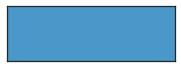

inconclusive


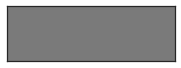

bilateral


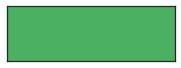

left


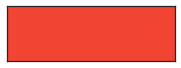

In [12]:
for c in cDict:
    print c
    sns.palplot(cDict[c])
    plt.show()

### make swarmplot

In [13]:
def makeSnsDf(maxDf):
    snsDf = pd.DataFrame(maxDf)
    snsDf.columns = ['y']
    snsDf['hue'] = [snsDf.index.levels[0][x] for x in snsDf.index.labels[0]]
    snsDf['x'] = [0 for x in snsDf.index]
    return snsDf

### make the background

In [14]:
def cmyk2rgb(l, bi, r, inc):

    c = float(l)
    m = float(bi)
    y = float(r)
    k = float(inc)

    r = round(255.0 - ((min(1.0, c * (1.0 - k) + k)) * 255.0))
    g = round(255.0 - ((min(1.0, m * (1.0 - k) + k)) * 255.0))
    b = round(255.0 - ((min(1.0, y * (1.0 - k) + k)) * 255.0))

    # mute the colors so they don't look as loud
    r = round(r * 0.6 + 10 * 0.4)
    g = round(g * 0.6 + 10 * 0.4)
    b = round(b * 0.6 + 10 * 0.4)

    return [r, g, b]

## make the 1d plot

### first part: the swarmplot with the data

In [15]:
def makeSwarm(snsDf, probPredsDf, ax):

    # first element: the data as a swarmplot

    snsDf.sort_index(inplace=True)
    theseColors = [
        cDict[x] for x in snsDf.index.remove_unused_levels().levels[0]
    ]

    sns.swarmplot(
        data=snsDf,
        x='y',
        y='x',
        hue='hue',
        orient='h',
        palette=theseColors,
        size=8,
        edgecolor='white',
        linewidth=1,
        ax=ax)

    # second element: the background
    for i in probPredsDf.index:
        thesePreds = pd.DataFrame(
            probPredsDf.
            loc[i, ['left', 'bilateral', 'right', 'inconclusive']]).fillna(0)

        theseColors = cmyk2rgb(*thesePreds.values)
        formatRgb = 1 - (np.array(theseColors) / 255.)
        ax.axvline(i, color=tuple(formatRgb), linewidth=10)

    # get rid of axes labels
    ax.set_xlim(1.01, -1.01, -0.2)
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_ylabel('')
    ax.set_ylim(-0.32, 0.32)
    ax.legend_.remove()
    
    return ax

### second part: probability curves

In [16]:
def makeProbCurves(probPredsDf, ax, cDict=cDict):

    for i in probPredsDf.columns:
        ax.plot(probPredsDf[i], c=cDict[i], label=i, linewidth=7, alpha=0.8)

    ax.set_xlim(1.01, -1.01, -0.2)
    ax.set_xticks(np.arange(1.0, -1.01, -0.2))
    ax.set_xlabel('Laterality Index (L-R)/(L+R)')
    ax.set_yticks([0, 1])
    ax.set_yticklabels([0, 1])
    ax.set_ylabel('p(Class)')
    ax.set_ylim(-0.03, 1.03)

    return ax

### combination of both

In [17]:
def makeFullPlot(snsDf, probPredsDf, myTitle, makeLegend=False):

    # make the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

    # first subplot: the data and the color background
    ax1 = plt.subplot2grid((4, 1), (0, 0), rowspan=3)
    ax1 = makeSwarm(snsDf, probPredsDf, ax1)

    # plot legend
    if makeLegend:
        # make font of legend white
        legend = plt.legend(frameon=1)
        frame = legend.get_frame()
        frame.set_facecolor('white')

    # second subplot: the probability curves
    ax2 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
    ax2 = makeProbCurves(probPredsDf, ax2)

    sns.despine()
    plt.suptitle(myTitle, y=.92)
    plt.close()
    return fig

### function to get the data and feed them into figure function

In [18]:
def bigPlotMaker(myTitle, drop, allAvgLiDf=allAvgLiDf, makeLegend=False):

    dropStr = ['full', 'drop'][drop]

    # load the data
    thisAvgLiDf = allAvgLiDf.loc[:, [dropStr]]

    probPredsDf = pd.read_csv(
        '../models/probPreds_clf_1d_%s.csv' % dropStr, index_col=[0])

    # get the data into seaborn-friendly format
    snsDf = makeSnsDf(thisAvgLiDf)
    if drop:
        snsDf.drop('inconclusive', inplace=True)

    # make the plot
    fig = makeFullPlot(snsDf, probPredsDf, myTitle, makeLegend)

    return fig

In [19]:
sns.set_style('white')

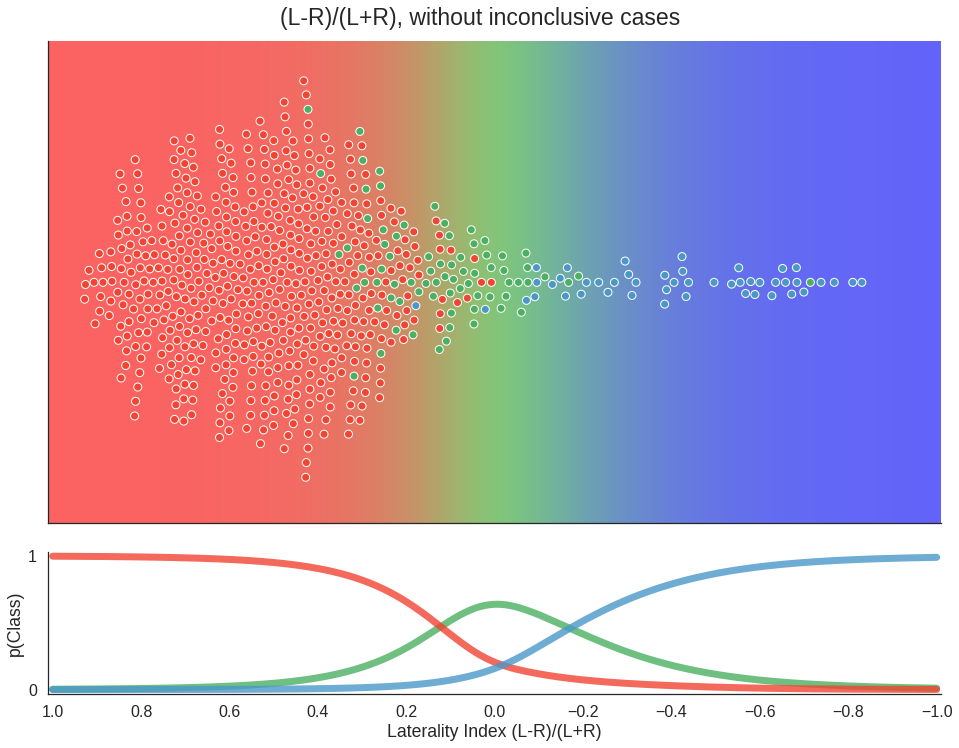

In [20]:
fig = bigPlotMaker('(L-R)/(L+R), without inconclusive cases', drop=True)
fig.savefig('../temp/11-swarm-1d-drop.png',dpi=300,bbox_inches='tight')
fig

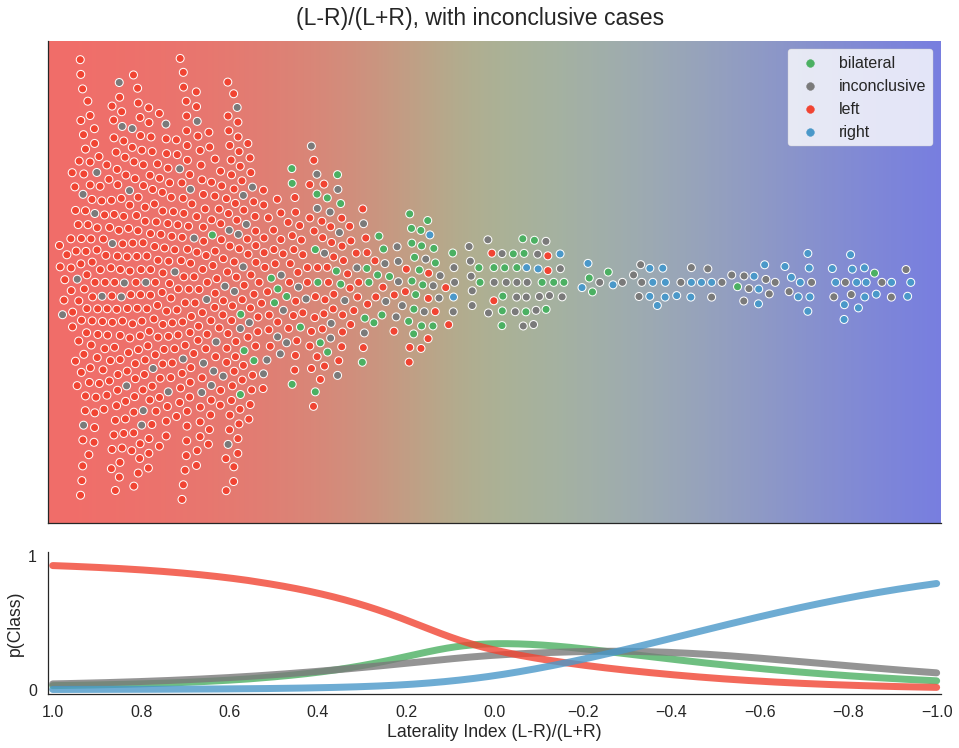

In [21]:
fig = bigPlotMaker('(L-R)/(L+R), with inconclusive cases', drop=False, makeLegend=True)
fig.savefig('../temp/11-swarm-1d-full.png',dpi=300,bbox_inches='tight')
fig

### merge into one figure

In [22]:
sns.set_style('dark')

In [23]:
figs = ['../temp/%s'%f for f in os.listdir('../temp/') if f.startswith('11-swarm-1d')]
figs

['../temp/11-swarm-1d-drop.png', '../temp/11-swarm-1d-full.png']

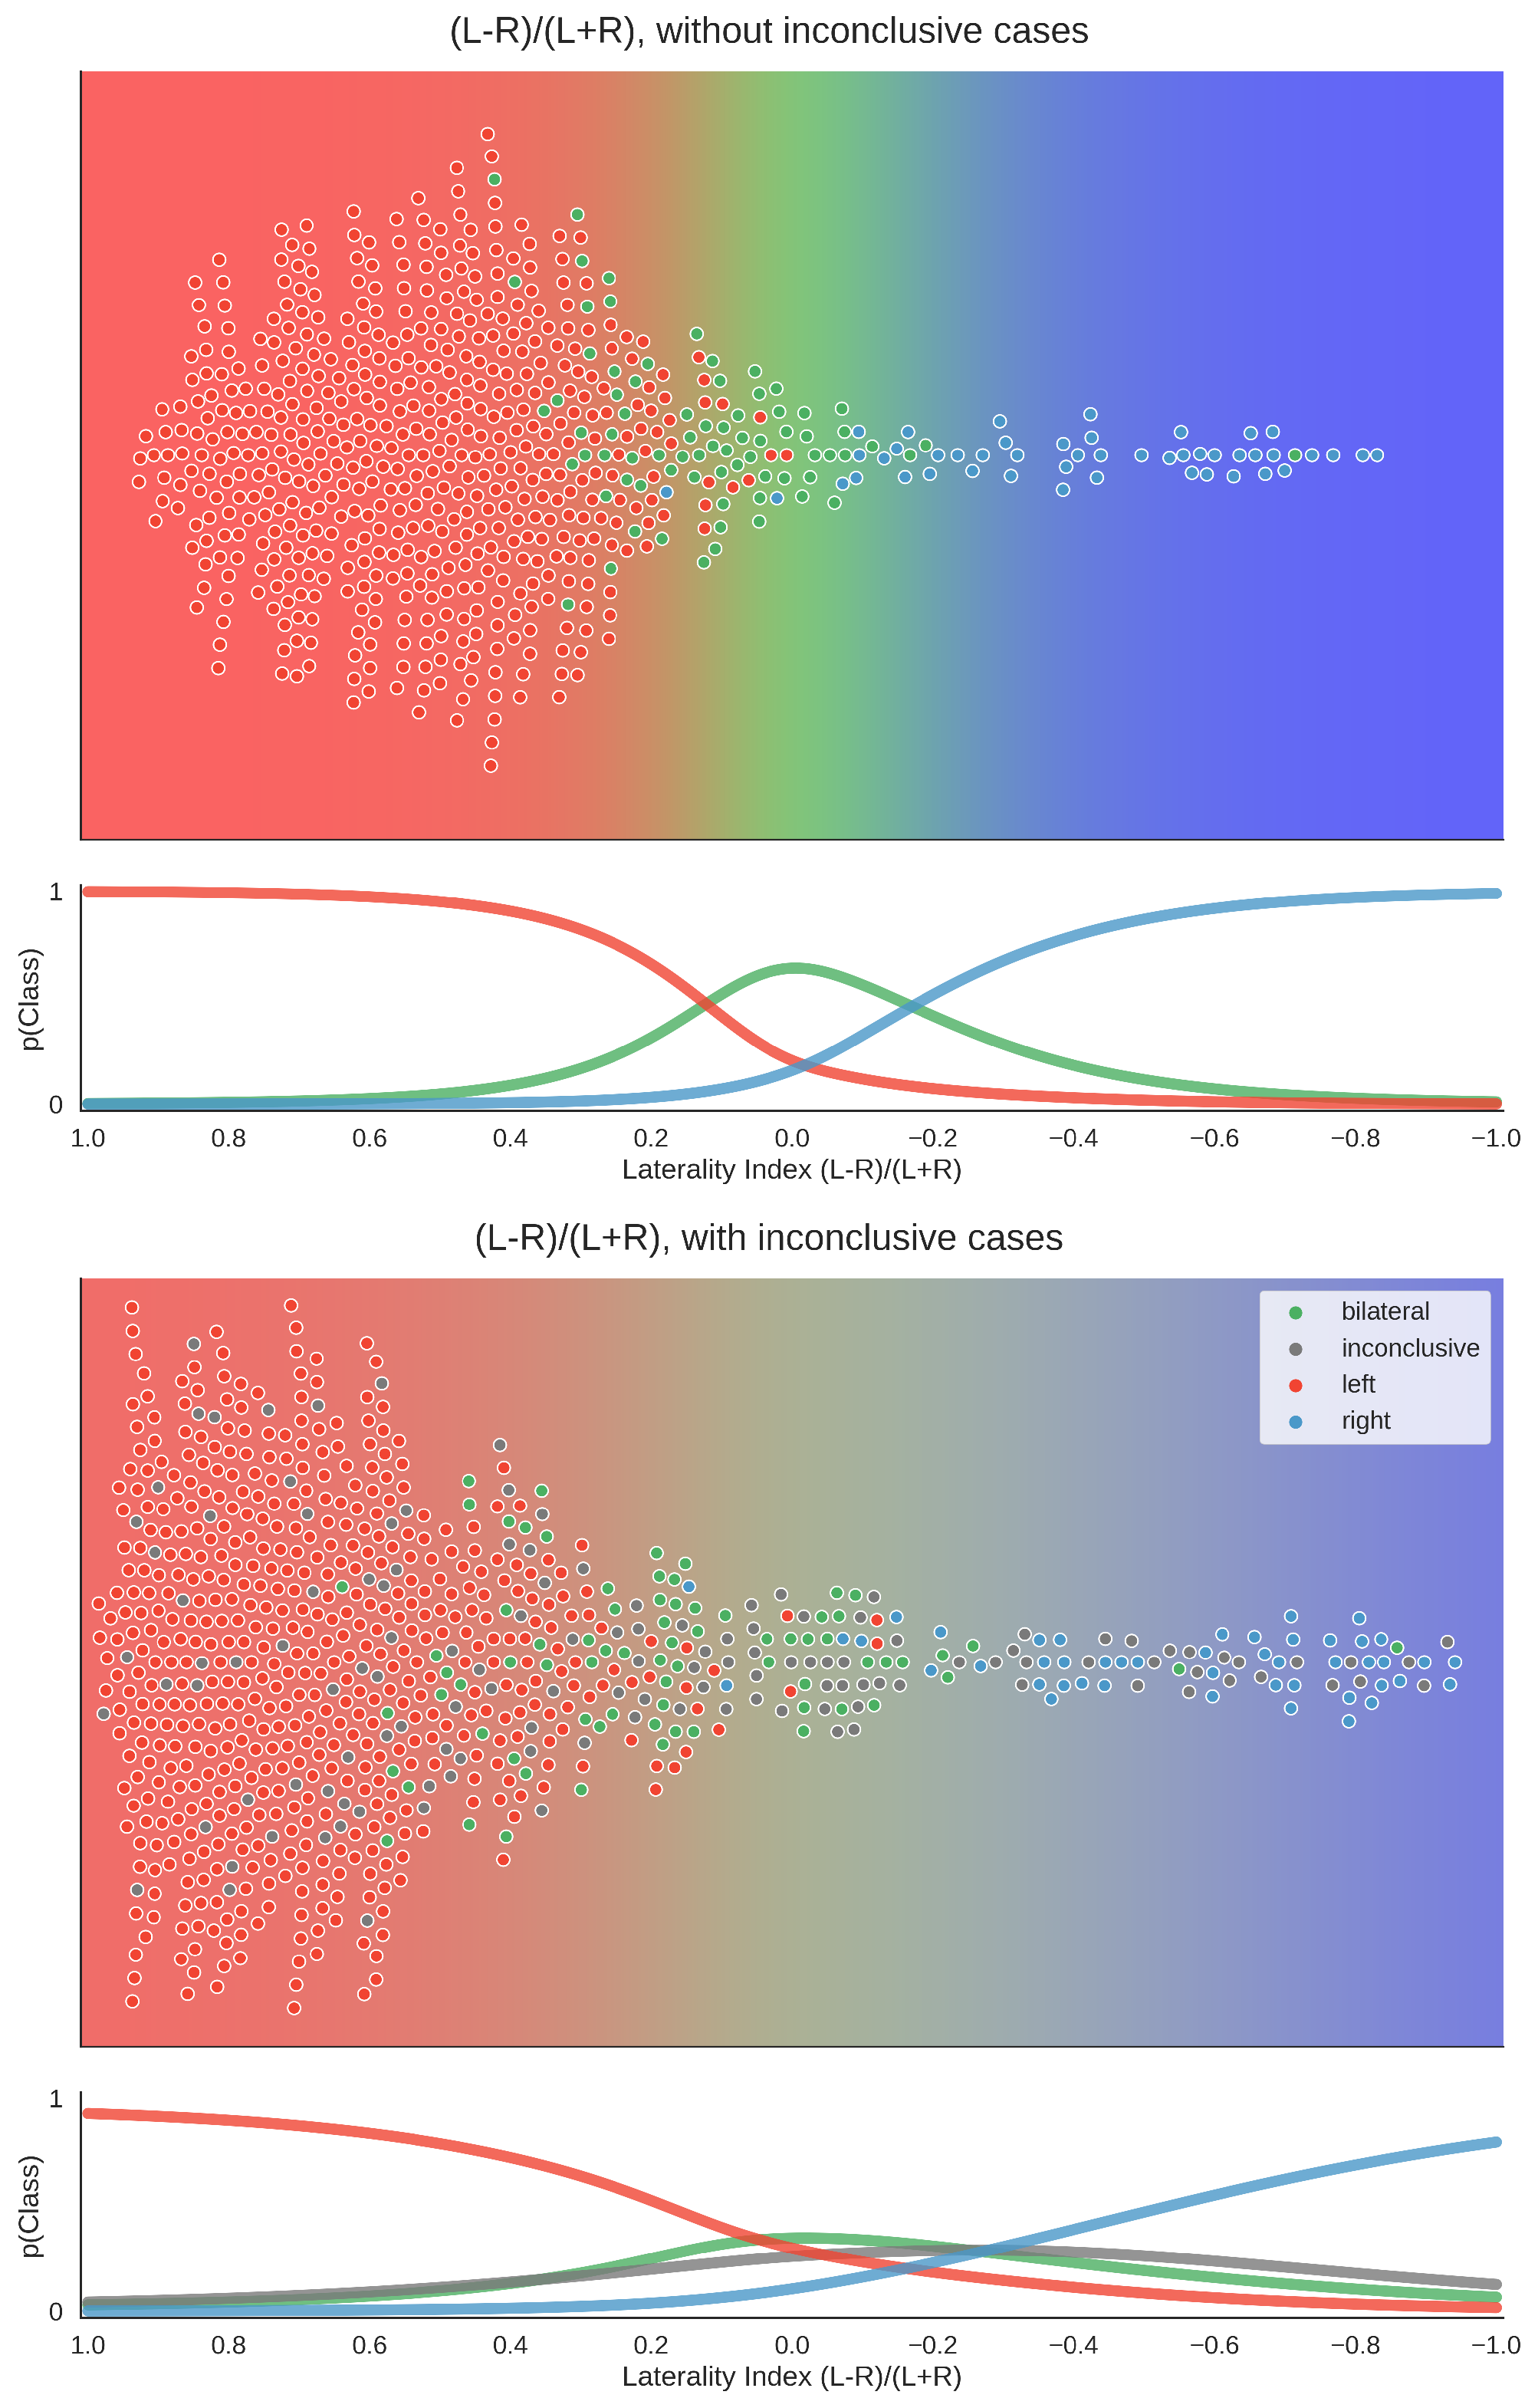

In [24]:
fig = plt.figure(figsize=(32, 44))

for i, imName in enumerate(figs):
    ax = plt.subplot(2,1,i+1)
    ax.imshow(plt.imread(imName))

    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.close()

fig.savefig('../reports/figures/11-swarm-1d.png',dpi=300,bbox_inches='tight')
fig

## make 2d plots

In [25]:
sns.set_style('white')

### make prediction space

In [26]:
def makePredSpace(clfDict,
                  aboveDf,
                  x_min=-1,
                  x_max=1,
                  y_min=-0.1,
                  y_max=1.7,
                  myLabeler=myLabeler):

    predDf = pd.DataFrame()
    for x in np.arange(x_min, x_max, .1):
        for y in np.arange(y_min, y_max, .1):
            thesePreds = doFixedPred([x, y], clfDict, aboveDf)
            thesePreds.columns = pd.MultiIndex.from_arrays([[y], [x]])
            thesePreds = thesePreds.T
            predDf = pd.concat([predDf, thesePreds])

    return predDf

### re-loading and plotting

In [27]:
from tqdm import tqdm_notebook

Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


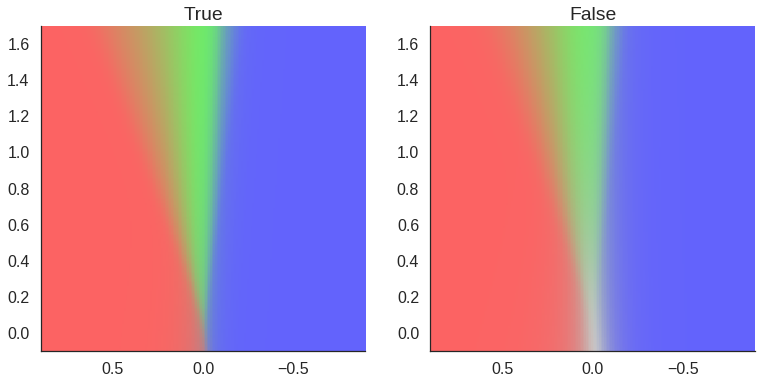

In [28]:
fig = plt.plot(figsize=(16, 10))

for n, myDrop in enumerate(tqdm_notebook([True, False],leave=True)):

    dropStr = ['full', 'drop'][myDrop]

    predSpaceDf = pd.read_csv(
        '../models/probPreds_clf_2d_%s.csv' % dropStr, index_col=[0, 1])
    predSpaceDf.sort_index(inplace=True)

    bigDf = pd.DataFrame()
    for i in tqdm_notebook(predSpaceDf.index,leave=False):

        if 'inconclusive' not in predSpaceDf.columns:
            predSpaceDf.loc[:, 'inconclusive'] = 0

        theseVals = predSpaceDf.loc[
            i, ['left', 'bilateral', 'right', 'inconclusive']]
        theseColors = cmyk2rgb(*theseVals.values)

        thisDf = pd.DataFrame(
            theseColors,
            index=['r', 'g', 'b'],
            columns=pd.MultiIndex.from_tuples([i])).T

        bigDf = pd.concat([bigDf, thisDf])

    colorDf = pd.DataFrame(index=bigDf.index)
    
    for i in tqdm_notebook(bigDf.index,leave=False):
        colorDf.loc[i, 'rgb'] = 'dummy'
        colorDf.loc[i, 'rgb'] = bigDf.loc[i, :].values
    colorDf = colorDf.unstack()['rgb']
    # transform df to 3d array
    a = np.array([list(i) for i in np.array(colorDf)])

    pickle.dump(a, open('../temp/colors_2d_%s.p'%dropStr,'wb'))
    ax = plt.subplot(1, 2, n + 1)
    ax.imshow(
        a, origin='lower', extent=(-0.9, 0.9, -0.1, 1.7), interpolation='none')
    ax.set_xlim(0.9, -0.9, -0.1)
    ax.set_title(str(myDrop))

sns.despine()
plt.show()

### get data:

In [29]:
allAvg2dDf = pd.DataFrame()

for pGroup, pName in my_all:
    try:
        csv = '../data/processed/csv/meanTable_%s.csv' % pName

        pDf = pd.read_csv(csv, index_col=[0, 1], header=0)
        pDf = pDf.loc['2d', ['L-R', 'L+R']]
        pDf = pd.DataFrame(pDf.stack()).T
        pDf.index = [[pGroup], [pName]]
        allAvg2dDf = pd.concat([allAvg2dDf, pDf])
    except:
        print pGroup, pName

allAvg2dDf.sort_index(inplace=True)

### wrap it into one plot (data + space)

In [30]:
def bigPlotMaker(ax, drop=True, allAvg2dDf=allAvg2dDf):

    dropStr = ['full', 'drop'][drop]

    # load the data
    thisAvg2dDf = allAvg2dDf.loc[:, dropStr]

    if drop:
        thisAvg2dDf.drop('inconclusive', inplace=True)
        # hard coded, to get the desired order
        groupList = ['left', 'right', 'bilateral']
    else:
        groupList = ['left', 'right', 'bilateral', 'inconclusive']

    for group in groupList:
        groupDf = thisAvg2dDf.loc[group]
        lbl = True
        for pName in groupDf.index:
            thisDf = groupDf.loc[pName]
            if lbl:
                ax.plot(
                    thisDf['L-R'],
                    thisDf['L+R'],
                    'o',
                    c=cDict[group],
                    alpha=0.7,
                    markeredgecolor='white',
                    markeredgewidth=1,
                    label=group)
            else:
                ax.plot(
                    thisDf['L-R'],
                    thisDf['L+R'],
                    'o',
                    c=cDict[group],
                    alpha=0.7,
                    markeredgecolor='white',
                    markeredgewidth=1)
            lbl = False

    predSpaceDf = pd.read_csv(
        '../models/probPreds_clf_2d_%s.csv' % dropStr, index_col=[0, 1])
    predSpaceDf.sort_index(inplace=True)
    
    try:
        a = pickle.load(open('../models/colors_2d_%s.p'%dropStr, 'rb'))
    except:
        a = pickle.load(open('../temp/colors_2d_%s.p'%dropStr, 'rb'))
        
    ax.imshow(
        a, origin='lower', extent=(-0.9, 0.9, -0.1, 1.7), interpolation='none')

    ax.set_xlim(0.7, -0.7, -0.1)
    ax.set_ylim(-0.05, 1.35, 0.1)

    if drop == False:
        
        b = pickle.load(open('../models/contours_2d_full.p', 'rb'))

        ax.contour(
            b,
            colors=('white'),
            levels=[0],
            alpha=0.9,
            origin='lower',
            extent=(-0.9, 0.9, -0.1, 1.7),
            antialiased=True,
            zorder=99)

    return ax

/data/martin/frontSub/venv/lib/python2.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


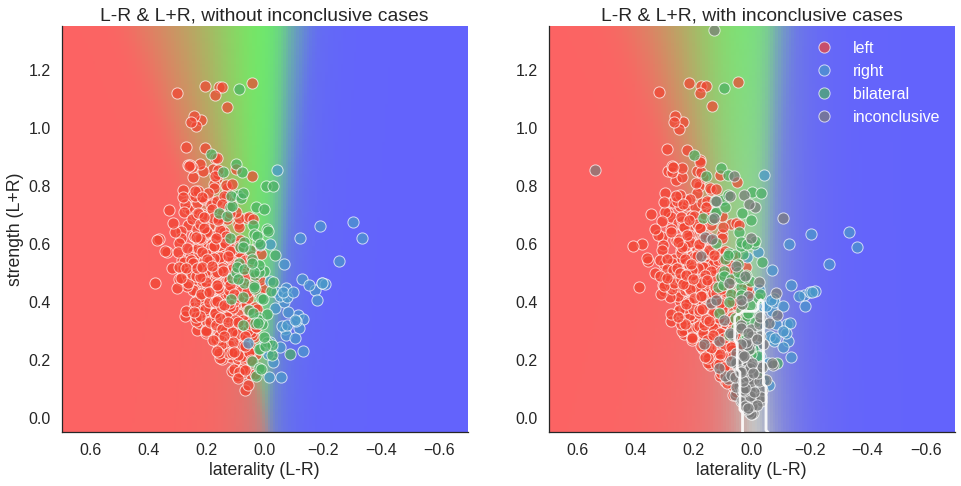

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 16))

ax1 = bigPlotMaker(ax1, drop=True)

ax1.set_ylabel('strength (L+R)')
ax1.set_xlabel('laterality (L-R)')

ax2 = bigPlotMaker(ax2, drop=False)

ax2.set_xlabel('laterality (L-R)')
ax2.legend(loc='upper right')
l = ax2.legend()
for text in l.get_texts():
    text.set_color("white")

ax1.set_title('L-R & L+R, without inconclusive cases')
ax2.set_title('L-R & L+R, with inconclusive cases')

sns.despine()
fig.savefig('../reports/figures/11-swarm-2d.png', dpi=300, bbox_inches='tight')